In [0]:
# Ignore this cell
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/datasets/finance_social/Dataset')
os.listdir()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


['StockTwits',
 'Twitter',
 'ReutersNews',
 'stocktwits.pkl',
 'stocktwits_clean.pkl',
 'twiters_label_data_Feb-02-2020.xlsx',
 'Collect twiter data.ipynb',
 'Stocktwits Label Model training with twiter data.ipynb',
 'github data',
 'stocktwits_sentiment_subjectivity_Feb-01-2020_p.xlsx']

In [0]:
from pathlib import Path
import json
import re
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import html

nltk.download('punkt')
from nltk import sent_tokenize, word_tokenize, wordpunct_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [0]:
file_path = Path("StockTwits/AAPL.json")
stocktwits_dir = Path("StockTwits")
twitter_dir = Path("Twitter")
stocktwits_filename = 'stocktwits.pkl'

In [0]:
with open(file_path, "r") as file:
  raw_file_data = json.load(file)
data  = pd.DataFrame(raw_file_data['messages'])
print(data.columns)
print(data.shape)
data.head()

Index(['id', 'body', 'created_at', 'user', 'source', 'symbols',
       'mentioned_users', 'entities', 'filters', 'reshare_message', 'likes',
       'links', 'conversation', 'reshares'],
      dtype='object')
(9870, 14)


,id,body,created_at,user,source,symbols,mentioned_users,entities,filters,reshare_message,likes,links,conversation,reshares
0,191505381,$AAPL down a dollar pm i wont be touching this...,2020-01-23T07:40:55Z,"{'id': 1912014, 'username': 'TheAssassin', 'na...","{'id': 1149, 'title': 'StockTwits for iOS', 'u...","[{'id': 686, 'symbol': 'AAPL', 'title': 'Apple...",[],{'sentiment': None},"{'day_counts': 177, 'official_api': True}",NaN,NaN,NaN,NaN,NaN
1,191505097,$AAPL,2020-01-23T07:26:35Z,"{'id': 2995764, 'username': 'Hk808', 'name': '...","{'id': 1149, 'title': 'StockTwits for iOS', 'u...","[{'id': 686, 'symbol': 'AAPL', 'title': 'Apple...",[],{'sentiment': None},"{'day_counts': 0, 'official_api': True}","{'reshared_count': 1, 'reshared_deleted': Fals...",NaN,NaN,NaN,NaN
2,191504907,$AAPL 📈,2020-01-23T07:17:08Z,"{'id': 1814718, 'username': '5tock0pt10nsTrad3...","{'id': 1149, 'title': 'StockTwits for iOS', 'u...","[{'id': 686, 'symbol': 'AAPL', 'title': 'Apple...",[],{'sentiment': {'basic': 'Bullish'}},"{'day_counts': 28, 'official_api': True}",NaN,"{'total': 1, 'user_ids': [385104]}",NaN,NaN,NaN
3,191504855,$SPY $AAPL Shorting and volatility is a thing ...,2020-01-23T07:14:03Z,"{'id': 394973, 'username': 'UptrendCapitalLLC'...","{'id': 2269, 'title': 'StockTwits Web', 'url':...","[{'id': 686, 'symbol': 'AAPL', 'title': 'Apple...",[],{'sentiment': None},"{'day_counts': 7, 'official_api': True}",NaN,"{'total': 1, 'user_ids': [961088]}",NaN,NaN,NaN
4,191504175,$SPY https://www.dailystar.co.uk/news/world-ne...,2020-01-23T06:46:01Z,"{'id': 257995, 'username': 'bottom_fisher', 'n...","{'id': 1149, 'title': 'StockTwits for iOS', 'u...","[{'id': 686, 'symbol': 'AAPL', 'title': 'Apple...",[],{'sentiment': None},"{'day_counts': 12, 'official_api': True}",NaN,"{'total': 1, 'user_ids': [1075370]}",[{'title': 'Global killer virus blamed on bat ...,NaN,NaN


In [0]:
'''
function to combine all JSON files in the file_dir param and return as a single data frame
parameters:
  file_dir -> directory containing all JSON files to be combined
  verbose -> flag to print progress and info about individual data files
  file_col -> name of the column containing file name in the combined dataframe
'''
def combine_data(file_dir, verbose=False, file_col='ticker'):
  dfs =[]
  cols = set()
  for filename in os.listdir(file_dir):
    with open(file_dir / filename, "r") as file:
      raw_file_data = json.load(file)
    df  = pd.DataFrame(raw_file_data['messages'])
    df[file_col] = filename.split('.')[0]
    if verbose:
      print(f'Shape of {file}: {df.shape}')
      print(f'New columns: {set(df.columns).difference(cols)}')
      print(f'Missing columns: {set(cols).difference(df.columns)}\n')
    cols.update(df.columns)
    dfs.append(df)
  return pd.concat(dfs, ignore_index=True,sort=False) # ignore_index to create new index, 'sort' when concatenating dataframes have different columns

In [0]:
def preprocess(text):
  processed = re.sub(r'\B\$\s?\w+(\.\w+)?\b\s*', '', text)
  processed = re.sub(r',\s+','', processed) # commas not informative for sentiment
  processed = re.sub(r'\s', ' ', processed) # replace new line and tabspace with single space
  processed = re.sub('http\S+', '',  processed) # remove URLs
  processed = html.unescape(processed) # unescape html text
  return processed.strip()

In [0]:
def flatten_data(df):
  df['user_followers']  = df['user'].apply(lambda user: user['followers'])
  df['user_following'] = df['user'].apply(lambda user: user['following'])
  df['user_join_date'] = df['user'].apply(lambda user: user['join_date'])
  df['user_ideas'] = df['user'].apply(lambda user: user['ideas'])
  df['user_identity'] = df['user'].apply(lambda user: user['identity'])
  df['user_like_count'] = df['user'].apply(lambda user: user['like_count'])
  df['user_official'] = df['user'].apply(lambda user: user['official'])
  df['user_wtchlst_count'] = df['user'].apply(lambda user: user['watchlist_stocks_count'])
  df['username'] = df['user'].apply(lambda user: user['username'])
  df['sentiment'] = df['entities'].apply(lambda e: e['sentiment']['basic'] if e['sentiment'] else None)
  df['num_likes'] = df['likes'].apply(lambda l: (l['total'] if type(l) == dict else 0))
  df['num_reshares'] = df['reshares'].apply(lambda l: (l['reshared_count'] if type(l) == dict else 0))
  df['num_replies'] = df['conversation'].apply(lambda c: c['replies'] if type(c) == dict else 0)
  df['day_counts'] = df['filters'].apply(lambda f: f['day_counts'] )
  # TODO extract similar stats of resharer from reshare_message 
  return df

In [0]:
data = flatten_data(data)
data['raw_body'] = data['body']
data['body'] = data['body'].apply(preprocess)

NameError: ignored

In [0]:
# filters, entities, mentioned_users, source
# len([d for d in data['mentioned_users'] if len(d)>0])

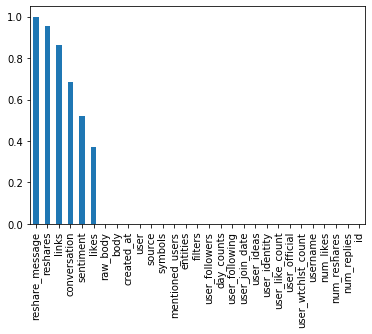

In [0]:
data.isnull().mean().sort_values(ascending=False).plot(kind='bar')

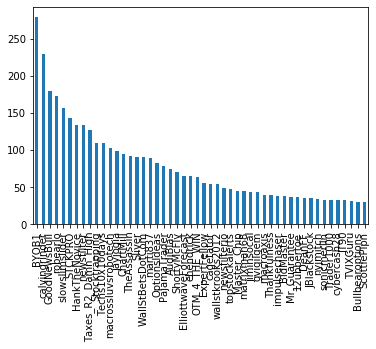

In [0]:
data['username'].value_counts()[:50].plot(kind='bar')

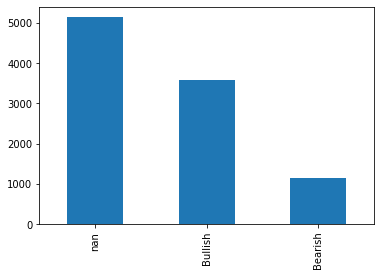

In [0]:
data['sentiment'].value_counts(dropna=False).plot(kind='bar')

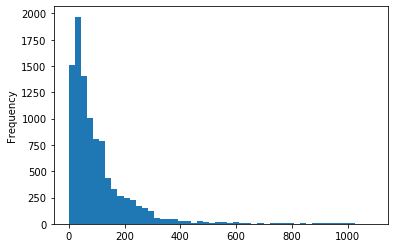

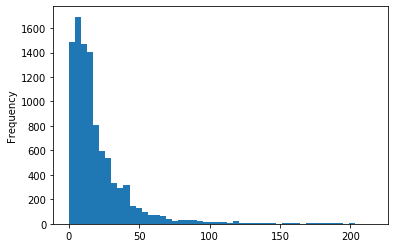

In [0]:
data['char_length'] = data['body'].apply(lambda t:len(t))
data['char_length'].plot.hist(bins=50)
plt.show()
data['word_length'] = data['body'].apply(lambda t:len(word_tokenize(t)))
data['word_length'].plot.hist(bins=50)

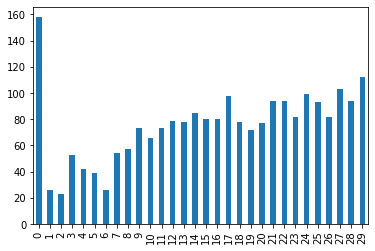

In [0]:
data['char_length'].value_counts().loc[list(range(30))].plot(kind='bar')

In [0]:
data = data.loc[data['char_length'] >0,:] # drop rows with preprocessed text length < 0
data = data.reset_index(drop=True) # reset the index from 0 after dropping rows
data.shape

(9712, 31)

In [0]:
data.loc[data['char_length'] <10,['body']]

,body
1,📈
6,ANALYSIS
9,meatless.
20,before ER
102,.
...,...
9587,So true
9589,LOL
9669,!
9671,🇺🇸🙏💪


In [0]:
text = data.iloc[9669]['raw_body']
print(text)
print(len(text))
preprocess(text)

$AAPL !
7


'!'

In [0]:
all_data = combine_data(stocktwits_dir, verbose=False)
print(all_data.shape)
all_data['ticker'].value_counts()

(140509, 16)


TWTR     10050
FB       10050
TSLA     10050
SPY      10050
GOOGL    10050
MSFT     10050
AMZN     10050
VIX      10050
DIA      10049
AMD      10049
INTC     10049
BABA     10049
YHOO     10043
AAPL      9870
Name: ticker, dtype: int64

(137207, 32)


(137207, 32)

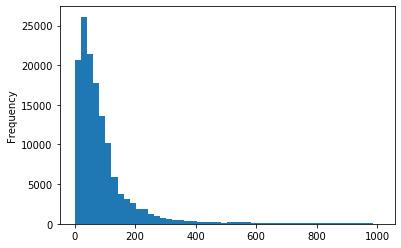

In [0]:
all_data = flatten_data(all_data)
all_data['raw_body'] = all_data['body']
all_data['body'] = all_data['body'].apply(preprocess)
all_data['char_length'] = all_data['body'].apply(lambda t:len(t))
all_data['char_length'].plot.hist(bins=50)
print(all_data.shape)
all_data = all_data.loc[all_data['char_length'] >0,:] # drop rows with preprocessed text length < 0
all_data = all_data.reset_index(drop=True) # reset the index from 0 after dropping rows
all_data.shape

In [0]:
# all_data = combine_data(stocktwits_dir, verbose=False)
all_data.to_pickle("stocktwits_clean.pkl")

In [0]:
all_data = pd.read_pickle("stocktwits.pkl")
# all_data = pd.read_pickle("stocktwits_sentiment_subjectivity_Jan-30-2020.pkl")
print(all_data.shape)

(140509, 31)


In [0]:
sent_data = all_data.loc[:,['body, raw_body', 'sentiment']]

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [0]:
sent_data.columns

Index(['body, raw_body', 'sentiment'], dtype='object')